In [1]:
%matplotlib inline

In [2]:
# from __future__ import print_function
import time
import numpy as np
import argparse
import io
import os
import sys
import datetime
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import animation
import matplotlib.gridspec as gridspec
from mpl_toolkits import mplot3d
from uncertainties import unumpy
import uncertainties as u
import itertools
import ucert
import seaborn as sns
import pandas as pd
from tqdm import tqdm
import scipy
import supplement as sp

In [3]:
from jupyterthemes import jtplot
jtplot.style()

#### Initial Config

##### This segment will be setting initial color schemes and building mappings for heatmaps

In [4]:
experiment = '/Users/TRD/Research_Personal/Quant_Mo/data/aw_motion/'
light_e = '/Users/TRD/Research_Personal/Light-Barometer/data/elles/data/'
e_name = 'aw_motion'
data = experiment + 'data'
pickled = experiment + 'pickled'
photos = experiment + 'photos'
filt = experiment + 'filt'
day = 'final'
color1 = '#bf5700'
color2 = '#808080'
rgb_color1 = mpl.colors.to_rgb(color1)
rgb_color2 = mpl.colors.to_rgb(color2)
my_cmap = mpl.colors.LinearSegmentedColormap.from_list('my_cmap', [rgb_color1, rgb_color2], N=100)

##### SETUP PROCESS - BUILDS DIRECTORY STRUCTURE

In [5]:
if os.path.exists(pickled) is False:
    os.makedirs(pickled)
if os.path.exists(photos) is False:
    os.makedirs(photos)
if os.path.exists(filt) is False:
    os.makedirs(filt)

In [6]:
plt.rcParams['figure.figsize'] = [13, 9]

#### Main Functions
-  main processing function which rebuilds the data into this system
-  edging function to remove heavy bias
-  normalization function

In [7]:
def intensity(x):
    # This is taking the hypotenuse of the intensity vectors
    assert type(x).__module__ == np.__name__
    return np.power(np.sum(np.power(x,2),axis=len(x.shape)-1),0.5) # pythagorean

In [8]:
A = np.load(day+'.npy')

In [9]:
A = sp.edge(A, (0.2, 0.74))

This function is looking to take something with an X and Y system to decompose it into a collapsed major system

In [10]:
# A = pythag(A)

This function yields the gradient (velocities at each given point within the graph - it's in experimental mode at the moment and prone to failure as it changes the dimensions of the matrix)

This code block underneath will normalize any matrix, showing relative weight between the matrices

In [11]:
print(A.shape)

(35, 35, 2)


In [12]:
A = sp.normalize(A)

In [13]:
def floaty(*args):
    ret = []
    for i in args:
        if type(i) is np.ndarray: 
            ret.append(i.astype('float64'))
        else:
            raise ValueError
    return ret

#### Analysis
-  Primary look is with the aveerage motion across a segment of the array
-  Secondary is taylor series fit and fourier analysis
-  Third is brief display of quality of fit vs taylor size
-  Fourth is motion vector display
-  Fifth, sixth, seventh are gradient display (i.e. proportional to the "force")

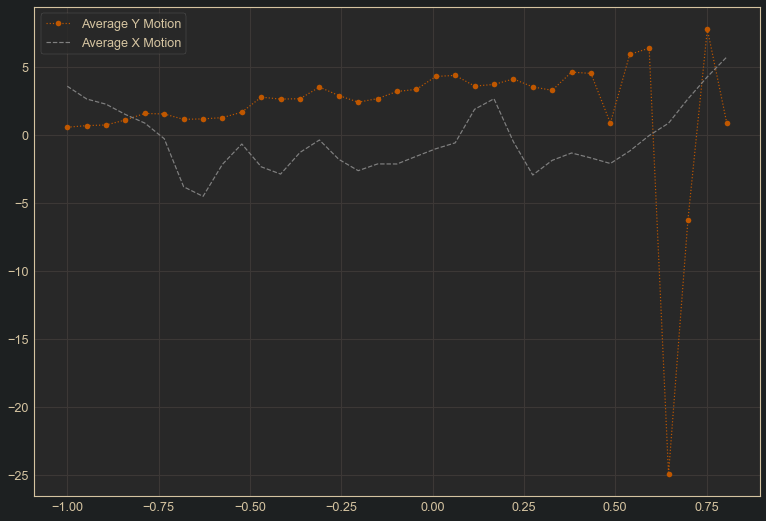

In [14]:
import matplotlib.pyplot as plt
X = np.linspace(np.min(A),np.max(A),num=A.shape[0])
y_motion = A[...,1]; x_motion = A[...,0];
y_avg = np.sum(y_motion, axis=1)
x_avg = np.sum(x_motion, axis=0)
max_val = np.max(y_motion.shape); min_val = 0
content = [X, y_avg, x_avg]
[X, y_avg, x_avg] = floaty(*content)
plt.plot(X,y_avg,'o:', color=color1, label="Average Y Motion")
plt.plot(X,x_avg,'--', color=color2, label="Average X Motion")
plt.legend(loc='best')
plt.show()

/Users/TRD/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:28: DeprecationWarning: object of type <class 'float'> cannot be safely interpreted as an integer.


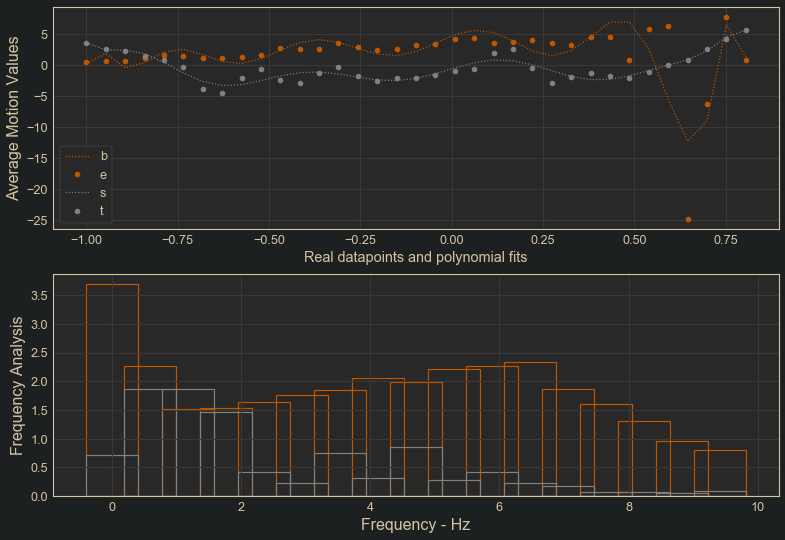

In [15]:
gs = gridspec.GridSpec(2,1, hspace=0.2)
fig = plt.figure()

poly_fit = 12
Vy = np.polyfit(X,y_avg,poly_fit)
Py = np.poly1d(Vy)
Vx = np.polyfit(X,x_avg,poly_fit)
Px = np.poly1d(Vx)

if y_avg.size == x_avg.size:
    N = y_avg.size;
else:
    raise

t = X[1]-X[0];

#first plot
ax = fig.add_subplot(gs[0])
ax.plot(X,Py(X),":", color=color1, label='Polyfit Terms'); ax.plot(X,y_avg,'o',color=color1, label="Average Motion Terms")
ax.plot(X,Px(X),":", color=color2, label='Polyfit Terms'); ax.plot(X,x_avg,'o',color=color2, label="Average Motion Terms")
ax.set_ylabel(r'Average Motion Values', size =16)
ax.set_xlabel(r'Real datapoints and polynomial fits')
ax.legend('best')

#second plot
ax = fig.add_subplot(gs[1])
fft_y = np.fft.fft(y_avg); fft_x = np.fft.fft(x_avg);
f = np.linspace(0.0, 1.0/(2.0*t), N/2)
ax.bar(f[:N], np.abs(fft_y)[:N // 2] * (2.0 / N), color=color1, fill=False, edgecolor=color1, linewidth=1.2)
ax.bar(f[:N], np.abs(fft_x)[:N // 2] * (2.0 / N), color=color2, fill=False, edgecolor=color2, linewidth=1.2)
ax.set_ylabel(r'Frequency Analysis', size =16)
ax.set_xlabel(r'Frequency - Hz', size =16)

plt.show()

In [16]:
residuals = []
test_range = 22
for i in range(test_range):
    Vy, residual, rank, singular_values, rcond = np.polyfit(X,y_avg,i,full=True)
    residuals.append(residual)
    
R = np.array(residuals)
R = R.flatten()
X_vals = np.array(range(test_range))
#plt.plot(X_vals, R, color=color1)
#plt.title("Residual Decrease with increased depth of taylor series")
#plt.show()

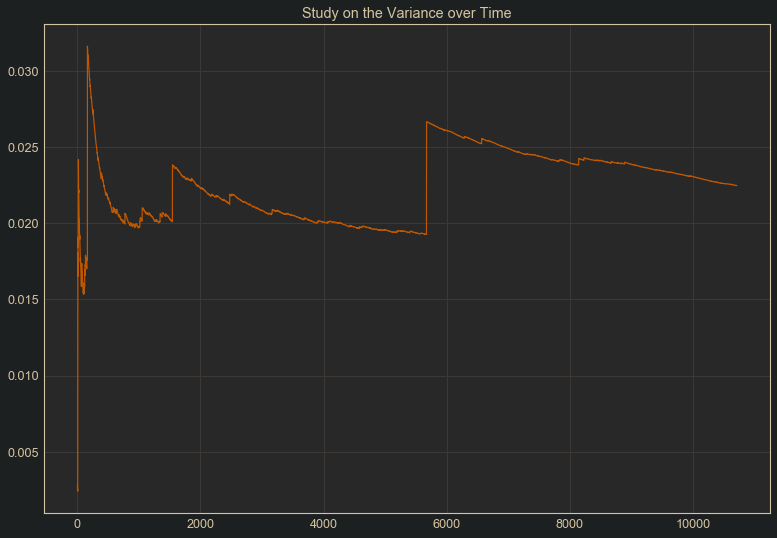

In [17]:
## This is a study on the variance over time of the system
var_evo = np.load(day+'_var.npy')
plt.plot(var_evo, color=color1)
plt.title("Study on the Variance over Time")
plt.show()

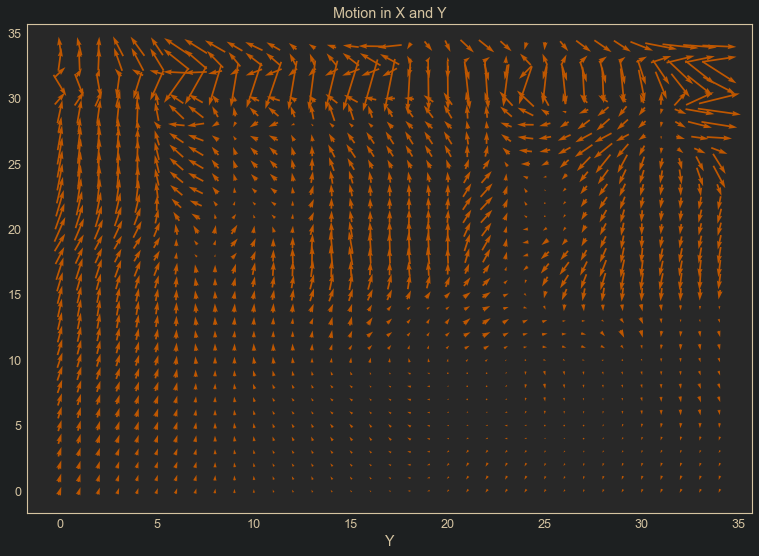

In [18]:
heat_x = np.linspace(np.min(A[0,...]), np.max(A[0,...]), num=A.shape[0])
heat_y = np.linspace(np.min(A[1,...]), np.max(A[1,...]), num=A.shape[1])
XX,YY = np.meshgrid(heat_x,heat_y)
plt.quiver(A[...,0],A[...,1], color='#bf5700', pivot='mid')
plt.grid(False)
plt.title("Motion in X and Y")
plt.xlabel("X")
plt.xlabel("Y")
#sns.jointplot(A[0,...], kind="hex", color="#4CB391")
plt.show()

#### This function is going to help us process our filtered arrays

In [19]:
def reshapeHelp(arr):
    # This function converts the array into an added dimension to support concatenation later
    assert type(arr).__module__ == np.__name__
    lis = list(arr.shape)
    lis.insert(0, 1)
    return np.reshape(arr, tuple(lis)).astype('float16')

def process(file):
    try:
        numObj = np.load(data+'/'+file)
        [date, arr] = numObj
        A = unumpy.matrix(arr.flatten())
        A_nom = np.ravel(A.nominal_values)
        outArr = np.reshape(A_nom, arr.shape)
        return [date, outArr]
    except EOFError:
        return None

##### Now we're going to think for a bit about how the data evolves over time

In [20]:
motion_files = [f for f in os.listdir(data) if os.path.isfile(os.path.join(data, f))]

In [21]:
# This builds a file for each hour of the day for post analysis

HOURS = 24
my_min = my_max = 0;
max_hour = min_hour = 0;
for HOUR in range(HOURS):
    # This is doing all the formatting we need
    outfile = str(HOUR)
    tee = [ i.strip('.npy').split('@',1)[-1] for i in motion_files ]
    dates = pd.DataFrame({'filename': motion_files,'date': tee})
    dates['date'] = pd.to_datetime(dates['date'], format='%Y-%m-%d.%H:%M:%S')
    dates['hour'] = pd.DatetimeIndex(dates['date']).hour
    filtered = dates[dates['hour']==HOUR]['filename'].values
    f_name = filt+'/'+outfile+e_name+'.npy'
    # This loads the file if need
    if os.path.isfile(f_name):
        M = np.load(f_name)
    # This builds a new file if need
    else:
        tempArr = np.array([], dtype='float16')
        for i in tqdm(filtered):
            temp = process(i)
            if temp is not None:
                [temp_date, arr] = temp
                if tempArr.size == 0:
                    tempArr = reshapeHelp(arr)
                else:
                    tempArr = np.concatenate([tempArr, reshapeHelp(arr)], axis=0)
        M = np.mean(tempArr, axis=0)
        np.save(filt+'/'+outfile+e_name, M)
        
# Going to be looking for max and mins between the arrays
for HOUR in range(HOURS):
    outfile = str(HOUR)
    if HOUR == 0:
        a_file = str(HOUR+1)
        b_file = '0'
    elif HOUR == HOURS-1:
        a_file = str(HOURS-1)
        b_file = str(HOUR-1)
    else:
        a_file = str(HOUR+1)
        b_file = str(HOUR-1)
    
    f_name = filt+'/'+outfile+e_name+'.npy';
    b_name = filt+'/'+b_file+e_name+'.npy';
    a_name = filt+'/'+a_file+e_name+'.npy';
    N = np.load(f_name); 
    N_a = np.load(a_name); 
    N_b = np.load(b_name)
    if np.amin(N-N_a) < my_min or np.amin(N-N_b) < my_min:
        my_min = np.amin(M)
        min_hour = HOUR
    if np.amax(N-N_a) > my_max or np.amax(N-N_b) > my_max:
        my_max = np.amax(M)
        max_hour = HOUR
            
print("Information about the max values: INDEX {}\t VALUE {}".format(max_hour, my_max))
print("Information about the min values: INDEX {}\t VALUE {}".format(min_hour, my_min))

Information about the max values: INDEX 0	 VALUE 0.035919189453125
Information about the min values: INDEX 9	 VALUE -0.0231475830078125


##### First thing we try to do is read a pickled file with the same hourly value to avoid extra processing

In [22]:
# Hour of interest here:
hour = 23
h = str(hour); h_b = str(hour-1); h_a = str(hour+1)
f_name = filt+'/'+h+e_name+'.npy'
f_before = filt+'/'+h_b+e_name+'.npy'
f_after = filt+'/'+h_a+e_name+'.npy'
M = np.load(f_name); # This should always work if the line before was run

# This is going to load the motion arrays for the hour before and after if they're avaliable
try:
    M_b = np.load(f_before)
except IOError as e:
    M_b = np.zeros_like(M)
    
try:
    M_a = np.load(f_after)
except IOError as e:
    M_a = np.zeros_like(M)

Max val is: 0.0043487548828125
Max val is: 0.12109375


NameError: name 'edge' is not defined

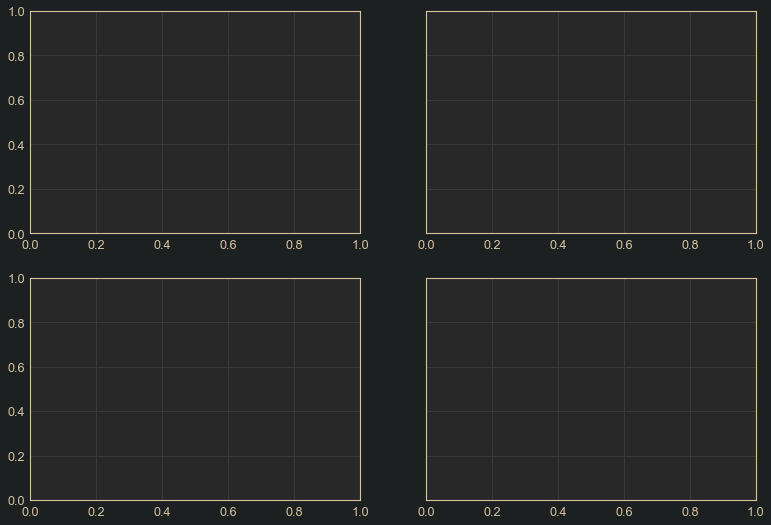

In [23]:
fig, axe = plt.subplots(2, 2, sharey='row')

MM_b = M - M_b; MM_a = M - M_a;
MM_bb = MM_b / my_max
MM_aa = MM_a / my_max
print("Max val is: {}".format(np.max(MM_b)))
print("Max val is: {}".format(np.max(MM_bb)))

e1 = 0.2; e2 = 0.74;
Mo = edge(M, (e1,e2)); MM_bb = edge(MM_bb, (e1,e2)); MM_aa = edge(MM_aa, (e1,e2));
Gx, Gy, Gz = np.gradient(Mo); GG = Gx+Gy
axe[0][0].quiver(Mo[...,0],Mo[...,1], color='#bf5700', pivot='mid')
axe[0][1].quiver(GG[...,0],GG[...,1], color='grey', pivot='mid')
# Going to make this the difference between the last hour and this hour
sns.heatmap(np.sum(MM_bb,axis=2), color=color2, ax=axe[1, 0])
sns.heatmap(np.sum(MM_aa,axis=2), color=color2, ax=axe[1, 1])
axe[1][1].invert_yaxis()
axe[1][0].invert_yaxis()

In [ ]:
## This is where I can study the light patterns on the time period

In [ ]:
l_files = os.listdir(light_e)
print("The length of the files is: {}".format(len(l_files)))
fl_files = [ light_e+i for i in l_files ]
l_vals = np.array([])
for i in fl_files:
    a = np.load(i, encoding='latin1')
    avg = np.average(a[2])
    l_vals = np.append(arr=l_vals, values=avg)

tee = [ i.strip('.npy').split('@',1)[-1] for i in l_files ]
light = pd.DataFrame({'filename': fl_files,'date': tee})
light['date'] = pd.to_datetime(light['date'], format='%Y-%m-%d.%H:%M:%S')
light['hour'] = pd.DatetimeIndex(light['date']).hour
light['intensity'] = l_vals

In [ ]:
sns.lineplot(x='hour',y='intensity',data=light)

### This is a study on the time variance

In [ ]:
## This is going to collect our pickled data
lt_motion = pd.read_pickle(pickled+'/aw_motion_save.pkl')

In [ ]:
lt_motion['minute'] = pd.DatetimeIndex(lt_motion['Date']).minute
lt_motion['month'] = pd.DatetimeIndex(lt_motion['Date']).month
lt_motion['hour'] = pd.DatetimeIndex(lt_motion['Date']).hour

In [ ]:
sns.lineplot(x='minute',y='m',hue='xy', palette='Oranges', data=lt_motion)

In [ ]:
sns.lineplot(x='month',y='m',hue='xy', palette="Oranges", data=lt_motion)

In [ ]:
sns.lineplot(x='hour',y='m',data=lt_motion)